In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4370 - acc: 0.2875
Epoch 00001: val_loss improved from inf to 2.18721, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_3_conv_checkpoint/001-2.1872.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 2.4368 - acc: 0.2876 - val_loss: 2.1872 - val_acc: 0.2681
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7331 - acc: 0.4631
Epoch 00002: val_loss improved from 2.18721 to 1.51603, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_3_conv_checkpoint/002-1.5160.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.7330 - acc: 0.4631 - val_loss: 1.5160 - val_acc: 0.5218
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4354 - acc: 0.5512
Epoch 00003: val_loss improved from 1.51603 to 1.39472, saving mo

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2423 - acc: 0.9207
Epoch 00028: val_loss did not improve from 1.34823
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2423 - acc: 0.9207 - val_loss: 1.7274 - val_acc: 0.6052
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2425 - acc: 0.9213
Epoch 00029: val_loss did not improve from 1.34823
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2424 - acc: 0.9213 - val_loss: 1.8164 - val_acc: 0.6012
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2308 - acc: 0.9244
Epoch 00030: val_loss did not improve from 1.34823
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2308 - acc: 0.9244 - val_loss: 1.7489 - val_acc: 0.6087
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2248 - acc: 0.9249
Epoch 00031: val_loss did not improve from 1.34823
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9606
Epoch 00058: val_loss did not improve from 1.34823
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.1247 - acc: 0.9605 - val_loss: 2.0085 - val_acc: 0.6159
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9610
Epoch 00059: val_loss did not improve from 1.34823
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.1245 - acc: 0.9610 - val_loss: 2.3300 - val_acc: 0.5686

1D_CNN_custom_ch_32_DO_BN_3_conv Model


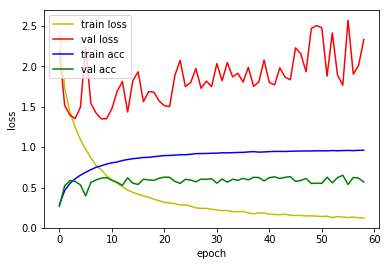

4815/4815 [==============================] - 2s 451us/sample - loss: 1.4817 - acc: 0.5676
Loss: 1.4816579678100712 Accuracy: 0.56760126

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4669 - acc: 0.2734
Epoch 00001: val_loss improved from inf to 1.80859, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_4_conv_checkpoint/001-1.8086.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.4670 - acc: 0.2734 - val_loss: 1.8086 - val_acc: 0.3932
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7003 - acc: 0.4728
Epoch 00002: val_loss improved from 1.80859 to 1.32835, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_4_conv_checkpoint/002-1.3284.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.7003 - acc: 0.4728 - val_loss: 1.3284 - val_acc: 0.5830
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4892 - acc: 0.8443
Epoch 00026: val_loss did not improve from 0.86484
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.4892 - acc: 0.8443 - val_loss: 0.9481 - val_acc: 0.7358
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4824 - acc: 0.8464
Epoch 00027: val_loss did not improve from 0.86484
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.4824 - acc: 0.8464 - val_loss: 0.8898 - val_acc: 0.7540
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4548 - acc: 0.8533
Epoch 00028: val_loss did not improve from 0.86484
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.4548 - acc: 0.8533 - val_loss: 0.9129 - val_acc: 0.7473
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4548 - acc: 0.8567
Epoch 00029: val_loss did not improve from 0.86484
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.2713 - acc: 0.9128
Epoch 00055: val_loss did not improve from 0.84548
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2714 - acc: 0.9128 - val_loss: 0.9201 - val_acc: 0.7722
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2741 - acc: 0.9099
Epoch 00056: val_loss did not improve from 0.84548
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2742 - acc: 0.9098 - val_loss: 0.8726 - val_acc: 0.7738
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2713 - acc: 0.9093
Epoch 00057: val_loss did not improve from 0.84548
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2714 - acc: 0.9093 - val_loss: 0.9224 - val_acc: 0.7645
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2663 - acc: 0.9115
Epoch 00058: val_loss did not improve from 0.84548
36805/36805 [========================

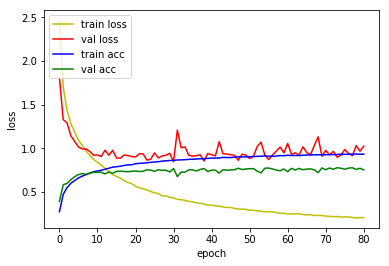

4815/4815 [==============================] - 2s 485us/sample - loss: 0.9394 - acc: 0.7377
Loss: 0.9393778567249778 Accuracy: 0.7376947

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4058 - acc: 0.2757
Epoch 00001: val_loss improved from inf to 1.72411, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_5_conv_checkpoint/001-1.7241.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.4056 - acc: 0.2757 - val_loss: 1.7241 - val_acc: 0.4393
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5712 - acc: 0.4979
Epoch 00002: val_loss improved from 1.72411 to 1.17531, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_5_conv_checkpoint/002-1.1753.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.5713 - acc: 0.4979 - val_loss: 1.1753 - val_acc: 0.6394
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.4557 - acc: 0.8598
Epoch 00026: val_loss did not improve from 0.64859
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4558 - acc: 0.8597 - val_loss: 0.7026 - val_acc: 0.7997
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4512 - acc: 0.8598
Epoch 00027: val_loss improved from 0.64859 to 0.64543, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_5_conv_checkpoint/027-0.6454.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4511 - acc: 0.8599 - val_loss: 0.6454 - val_acc: 0.8111
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4383 - acc: 0.8656
Epoch 00028: val_loss did not improve from 0.64543
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4384 - acc: 0.8656 - val_loss: 1.1574 - val_acc: 0.6930
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4285 - ac

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2694 - acc: 0.9141
Epoch 00055: val_loss did not improve from 0.63707
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2695 - acc: 0.9141 - val_loss: 0.7486 - val_acc: 0.8022
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2747 - acc: 0.9107
Epoch 00056: val_loss did not improve from 0.63707
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2748 - acc: 0.9107 - val_loss: 0.7905 - val_acc: 0.7911
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2722 - acc: 0.9136
Epoch 00057: val_loss did not improve from 0.63707
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2723 - acc: 0.9136 - val_loss: 0.7953 - val_acc: 0.7959
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2678 - acc: 0.9149
Epoch 00058: val_loss did not improve from 0.63707
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9379
Epoch 00085: val_loss did not improve from 0.63707
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1978 - acc: 0.9379 - val_loss: 0.7269 - val_acc: 0.8234
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1903 - acc: 0.9387
Epoch 00086: val_loss did not improve from 0.63707
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1904 - acc: 0.9387 - val_loss: 0.7332 - val_acc: 0.8127
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1920 - acc: 0.9382
Epoch 00087: val_loss did not improve from 0.63707
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1920 - acc: 0.9382 - val_loss: 0.7482 - val_acc: 0.8195
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9400
Epoch 00088: val_loss did not improve from 0.63707
36805/36805 [===========

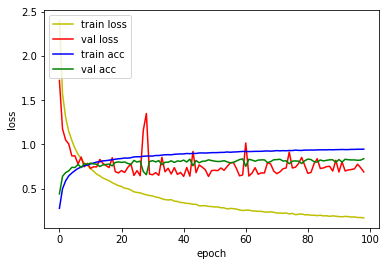

4815/4815 [==============================] - 3s 532us/sample - loss: 0.6981 - acc: 0.8039
Loss: 0.6980502425819667 Accuracy: 0.803946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5072 - acc: 0.2537
Epoch 00001: val_loss improved from inf to 1.69430, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_6_conv_checkpoint/001-1.6943.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.5071 - acc: 0.2537 - val_loss: 1.6943 - val_acc: 0.4486
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6385 - acc: 0.4740
Epoch 00002: val_loss improved from 1.69430 to 1.14882, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_6_conv_checkpoint/002-1.1488.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.6384 - acc: 0.4740 - val_loss: 1.1488 - val_acc: 0.6571
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.4563 - acc: 0.8651
Epoch 00024: val_loss did not improve from 0.47159
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4564 - acc: 0.8650 - val_loss: 0.4804 - val_acc: 0.8735
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4491 - acc: 0.8660
Epoch 00025: val_loss did not improve from 0.47159
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4491 - acc: 0.8659 - val_loss: 0.5440 - val_acc: 0.8456
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4341 - acc: 0.8711
Epoch 00026: val_loss improved from 0.47159 to 0.47020, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_6_conv_checkpoint/026-0.4702.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4343 - acc: 0.8711 - val_loss: 0.4702 - val_acc: 0.8675
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4240 - ac

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2881 - acc: 0.9114
Epoch 00051: val_loss did not improve from 0.38519
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2881 - acc: 0.9115 - val_loss: 0.4588 - val_acc: 0.8698
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2837 - acc: 0.9112
Epoch 00052: val_loss did not improve from 0.38519
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2840 - acc: 0.9111 - val_loss: 0.5301 - val_acc: 0.8553
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2796 - acc: 0.9140
Epoch 00053: val_loss did not improve from 0.38519
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2796 - acc: 0.9140 - val_loss: 0.5769 - val_acc: 0.8463
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2724 - acc: 0.9164
Epoch 00054: val_loss did not improve from 0.38519
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2090 - acc: 0.9344
Epoch 00080: val_loss did not improve from 0.35431
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2090 - acc: 0.9344 - val_loss: 0.3824 - val_acc: 0.9026
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2015 - acc: 0.9368
Epoch 00081: val_loss did not improve from 0.35431
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2018 - acc: 0.9367 - val_loss: 0.3900 - val_acc: 0.8966
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2042 - acc: 0.9365
Epoch 00082: val_loss did not improve from 0.35431
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2042 - acc: 0.9364 - val_loss: 0.3861 - val_acc: 0.8919
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9362
Epoch 00083: val_loss did not improve from 0.35431
36805/36805 [===========

Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9492
Epoch 00110: val_loss did not improve from 0.35431
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1562 - acc: 0.9492 - val_loss: 0.4234 - val_acc: 0.9001
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1556 - acc: 0.9497
Epoch 00111: val_loss did not improve from 0.35431
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1557 - acc: 0.9496 - val_loss: 0.4074 - val_acc: 0.8954
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1586 - acc: 0.9484
Epoch 00112: val_loss did not improve from 0.35431
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1587 - acc: 0.9483 - val_loss: 0.4065 - val_acc: 0.9001
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9510
Epoch 00113: val_loss did not improve from 0.35431
36805/36805 [=======

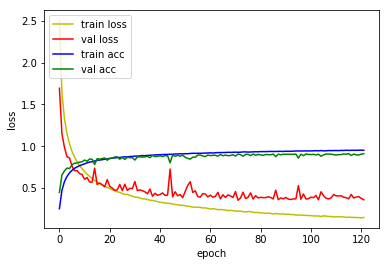

4815/4815 [==============================] - 3s 558us/sample - loss: 0.4171 - acc: 0.8827
Loss: 0.4171265884970826 Accuracy: 0.88265836

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6796 - acc: 0.2001
Epoch 00001: val_loss improved from inf to 1.94170, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_7_conv_checkpoint/001-1.9417.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.6795 - acc: 0.2002 - val_loss: 1.9417 - val_acc: 0.3988
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7998 - acc: 0.4182
Epoch 00002: val_loss improved from 1.94170 to 1.26337, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_7_conv_checkpoint/002-1.2634.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.7999 - acc: 0.4182 - val_loss: 1.2634 - val_acc: 0.6201
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3359 - acc: 0.8971
Epoch 00025: val_loss improved from 0.33131 to 0.31853, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_7_conv_checkpoint/025-0.3185.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3360 - acc: 0.8971 - val_loss: 0.3185 - val_acc: 0.9173
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3228 - acc: 0.9015
Epoch 00026: val_loss did not improve from 0.31853
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3228 - acc: 0.9015 - val_loss: 0.3440 - val_acc: 0.9045
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3097 - acc: 0.9072
Epoch 00027: val_loss improved from 0.31853 to 0.29228, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_7_conv_checkpoint/027-0.2923.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3098 - acc: 0.9072 - val_loss: 0

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1896 - acc: 0.9404
Epoch 00052: val_loss did not improve from 0.22322
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1896 - acc: 0.9404 - val_loss: 0.2250 - val_acc: 0.9390
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1853 - acc: 0.9413
Epoch 00053: val_loss did not improve from 0.22322
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1853 - acc: 0.9413 - val_loss: 0.2587 - val_acc: 0.9245
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9412
Epoch 00054: val_loss improved from 0.22322 to 0.22008, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_7_conv_checkpoint/054-0.2201.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1858 - acc: 0.9411 - val_loss: 0.2201 - val_acc: 0.9397
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9561
Epoch 00081: val_loss did not improve from 0.21274
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1330 - acc: 0.9561 - val_loss: 0.2312 - val_acc: 0.9404
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1293 - acc: 0.9582
Epoch 00082: val_loss did not improve from 0.21274
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1296 - acc: 0.9581 - val_loss: 0.2355 - val_acc: 0.9413
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1298 - acc: 0.9575
Epoch 00083: val_loss did not improve from 0.21274
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1298 - acc: 0.9575 - val_loss: 0.2190 - val_acc: 0.9434
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9589
Epoch 00084: val_loss did not improve from 0.21274
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9665
Epoch 00110: val_loss did not improve from 0.20918
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1007 - acc: 0.9665 - val_loss: 0.2267 - val_acc: 0.9401
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0918 - acc: 0.9699
Epoch 00111: val_loss did not improve from 0.20918
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0918 - acc: 0.9699 - val_loss: 0.2408 - val_acc: 0.9408
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9675
Epoch 00112: val_loss did not improve from 0.20918
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0973 - acc: 0.9675 - val_loss: 0.2347 - val_acc: 0.9427
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9708
Epoch 00113: val_loss did not improve from 0.20918
36805/36805 [=====================

Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9765
Epoch 00140: val_loss did not improve from 0.20918
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0713 - acc: 0.9765 - val_loss: 0.2663 - val_acc: 0.9411
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9770
Epoch 00141: val_loss did not improve from 0.20918
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0706 - acc: 0.9770 - val_loss: 0.2913 - val_acc: 0.9345
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 0.9742
Epoch 00142: val_loss did not improve from 0.20918
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0783 - acc: 0.9741 - val_loss: 0.2475 - val_acc: 0.9462
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0717 - acc: 0.9769
Epoch 00143: val_loss did not improve from 0.20918
36805/36805 [=======

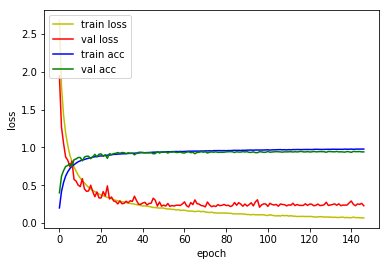

4815/4815 [==============================] - 3s 619us/sample - loss: 0.2484 - acc: 0.9294
Loss: 0.2484203779499355 Accuracy: 0.92938733

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8902 - acc: 0.1701
Epoch 00001: val_loss improved from inf to 2.09563, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_8_conv_checkpoint/001-2.0956.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.8902 - acc: 0.1701 - val_loss: 2.0956 - val_acc: 0.3527
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9450 - acc: 0.3808
Epoch 00002: val_loss improved from 2.09563 to 1.32522, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_8_conv_checkpoint/002-1.3252.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.9450 - acc: 0.3808 - val_loss: 1.3252 - val_acc: 0.6089
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9277
Epoch 00023: val_loss improved from 0.21128 to 0.20086, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_8_conv_checkpoint/023-0.2009.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2358 - acc: 0.9277 - val_loss: 0.2009 - val_acc: 0.9443
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9274
Epoch 00024: val_loss did not improve from 0.20086
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2368 - acc: 0.9273 - val_loss: 0.2260 - val_acc: 0.9324
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9295
Epoch 00025: val_loss improved from 0.20086 to 0.19231, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_8_conv_checkpoint/025-0.1923.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2263 - acc: 0.9295 - val_loss: 0.1923 - val_a

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9642
Epoch 00050: val_loss did not improve from 0.15293
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1130 - acc: 0.9642 - val_loss: 0.1729 - val_acc: 0.9555
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9638
Epoch 00051: val_loss did not improve from 0.15293
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1156 - acc: 0.9638 - val_loss: 0.1942 - val_acc: 0.9464
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9651
Epoch 00052: val_loss did not improve from 0.15293
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1121 - acc: 0.9651 - val_loss: 0.1754 - val_acc: 0.9488
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9673
Epoch 00053: val_loss did not improve from 0.15293
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9765
Epoch 00080: val_loss did not improve from 0.15293
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0709 - acc: 0.9766 - val_loss: 0.1835 - val_acc: 0.9532
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9784
Epoch 00081: val_loss did not improve from 0.15293
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0677 - acc: 0.9784 - val_loss: 0.1626 - val_acc: 0.9569
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9799
Epoch 00082: val_loss did not improve from 0.15293
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0624 - acc: 0.9799 - val_loss: 0.1826 - val_acc: 0.9529
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9821
Epoch 00083: val_loss did not improve from 0.15293
36805/36805 [===========

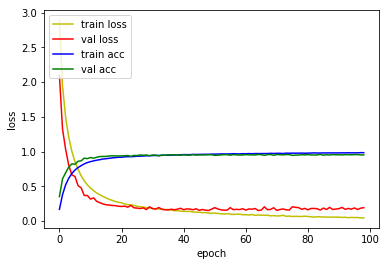

4815/4815 [==============================] - 3s 693us/sample - loss: 0.1976 - acc: 0.9391
Loss: 0.1975665055052885 Accuracy: 0.9391485

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4341 - acc: 0.2964
Epoch 00001: val_loss improved from inf to 1.53652, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_9_conv_checkpoint/001-1.5365.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.4339 - acc: 0.2964 - val_loss: 1.5365 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3253 - acc: 0.5812
Epoch 00002: val_loss improved from 1.53652 to 0.76083, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_9_conv_checkpoint/002-0.7608.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.3254 - acc: 0.5811 - val_loss: 0.7608 - val_acc: 0.7820
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9604
Epoch 00025: val_loss did not improve from 0.14572
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1276 - acc: 0.9604 - val_loss: 0.1869 - val_acc: 0.9434
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9618
Epoch 00026: val_loss did not improve from 0.14572
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1213 - acc: 0.9618 - val_loss: 0.1497 - val_acc: 0.9546
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9651
Epoch 00027: val_loss improved from 0.14572 to 0.14147, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_BN_9_conv_checkpoint/027-0.1415.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1129 - acc: 0.9651 - val_loss: 0.1415 - val_acc: 0.9578
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9865
Epoch 00054: val_loss did not improve from 0.13080
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0439 - acc: 0.9865 - val_loss: 0.1529 - val_acc: 0.9592
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9867
Epoch 00055: val_loss did not improve from 0.13080
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0428 - acc: 0.9867 - val_loss: 0.1719 - val_acc: 0.9541
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9859
Epoch 00056: val_loss did not improve from 0.13080
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0437 - acc: 0.9859 - val_loss: 0.1876 - val_acc: 0.9513
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9870
Epoch 00057: val_loss did not improve from 0.13080
36805/36805 [===========

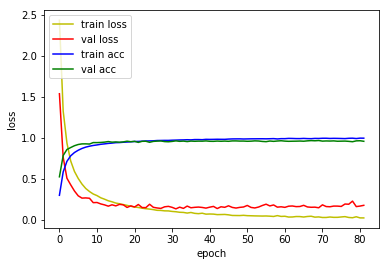

4815/4815 [==============================] - 3s 702us/sample - loss: 0.1950 - acc: 0.9425
Loss: 0.19495002571203254 Accuracy: 0.94247144



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [13]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_32_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 

4815/4815 [==============================] - 3s 683us/sample - loss: 0.6981 - acc: 0.8039
Loss: 0.6980502425819667 Accuracy: 0.803946

1D_CNN_custom_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation)   (None

4815/4815 [==============================] - 4s 744us/sample - loss: 0.2484 - acc: 0.9294
Loss: 0.2484203779499355 Accuracy: 0.92938733

1D_CNN_custom_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activation)   (No

4815/4815 [==============================] - 4s 814us/sample - loss: 0.1950 - acc: 0.9425
Loss: 0.19495002571203254 Accuracy: 0.94247144
